In [1]:
import pandas as pd
import numpy as np
import datetime 
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from datetime import timedelta
from KDEpy import FFTKDE
from array import array
%matplotlib inline

In [2]:
user_freetext_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/Desktop_Freetext.csv', header=0)
key_distance = pd.read_excel('C:/Research Activities/Dataset/Keyboard_distance.xlsx')

In [3]:
user_1_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/1/1_Desktop_Keyboard.csv', header=0)
user_2_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/2/2_Desktop_Keyboard.csv', header=0)

In [4]:
user_freetext_desktop['timestamp'] = pd.to_datetime(user_freetext_desktop['timestamp'])
user_1_desktop['time'] = pd.to_datetime(user_1_desktop['time'])
user_2_desktop['time'] = pd.to_datetime(user_2_desktop['time'])

In [5]:
user_1_fixedtext_desktop = user_1_desktop[user_1_desktop["time"]< (user_freetext_desktop.iloc[0,1])]
user_1_freetext_desktop = user_1_desktop[user_1_desktop["time"]>= (user_freetext_desktop.iloc[0,1])]

user_2_fixedtext_desktop = user_2_desktop[user_2_desktop["time"]< (user_freetext_desktop.iloc[1,1])]
user_2_freetext_desktop = user_2_desktop[user_2_desktop["time"]>= (user_freetext_desktop.iloc[1,1])]

In [6]:
user_1_fixedtext_desktop.name = 'user_1_fixedtext_desktop'
user_1_freetext_desktop.name = 'user_1_freetext_desktop'
user_2_fixedtext_desktop.name = 'user_2_fixedtext_desktop'
user_2_freetext_desktop.name = 'user_2_freetext_desktop' 

In [7]:
def sampling_users(dataset, sampling_frequency):
    time_limit= sampling_frequency
    min_time = dataset["time"].min()
    max_time = dataset["time"].max()
    time_gap = math.floor((max_time - min_time)/ timedelta(minutes=time_limit))
    samples = {}
    ID = dataset["EID"].values[0]
    
    for i in range(1,time_gap+1):
      
        df_name = dataset.name+'_'+ str(i)
        
        samples[df_name] = dataset[(dataset["time"]>= dataset["time"][ID])
        & (dataset["time"]<=dataset["time"][ID+1] + timedelta(minutes=time_limit))]
        
        if samples[df_name]["direction"].values[-1]== 0:
            samples[df_name] = dataset[(dataset["EID"]>= samples[df_name]["EID"].values[0]) & 
                                       (dataset["EID"]<= samples[df_name]["EID"].values[-1]+1)]
                
        else: 
            samples[df_name] = dataset[(dataset["EID"]>= samples[df_name]["EID"].values[0]) & 
                                       (dataset["EID"]<= samples[df_name]["EID"].values[-1])]
          
        ID = samples[df_name]["EID"].max()+1
        
      
            
    return samples

In [8]:
user_1_sample_1_desktop = sampling_users(user_1_fixedtext_desktop,3)['user_1_fixedtext_desktop_1']
user_1_sample_2_desktop = sampling_users(user_1_fixedtext_desktop,3)['user_1_fixedtext_desktop_2']
user_1_sample_3_desktop = sampling_users(user_1_fixedtext_desktop,3)['user_1_fixedtext_desktop_3']
user_1_sample_4_desktop = sampling_users(user_1_fixedtext_desktop,3)['user_1_fixedtext_desktop_4']
# user_1_sample_5_desktop = sampling_users(user_1_fixedtext_desktop,2)['user_1_fixedtext_desktop_5']
# user_1_sample_6_desktop = sampling_users(user_1_fixedtext_desktop,2)['user_1_fixedtext_desktop_6']

In [9]:
user_2_sample_1_desktop = sampling_users(user_2_fixedtext_desktop,3)['user_2_fixedtext_desktop_1']
user_2_sample_2_desktop = sampling_users(user_2_fixedtext_desktop,3)['user_2_fixedtext_desktop_2']
user_2_sample_3_desktop = sampling_users(user_2_fixedtext_desktop,3)['user_2_fixedtext_desktop_3']
user_2_sample_4_desktop = sampling_users(user_2_fixedtext_desktop,3)['user_2_fixedtext_desktop_4']
# user_2_sample_5_desktop = sampling_users(user_2_fixedtext_desktop,2)['user_2_fixedtext_desktop_5']
# user_2_sample_6_desktop = sampling_users(user_2_fixedtext_desktop,2)['user_2_fixedtext_desktop_6']

In [10]:
user_1_sample_1_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_1']
user_1_sample_2_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_2']
user_1_sample_3_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_3']
user_1_sample_4_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_4']
user_1_sample_5_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_5']
user_1_sample_6_desktop_free = sampling_users(user_1_freetext_desktop,5)['user_1_freetext_desktop_6']

In [11]:
user_2_sample_1_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_1']
user_2_sample_2_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_2']
user_2_sample_3_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_3']
user_2_sample_4_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_4']
user_2_sample_5_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_5']
user_2_sample_6_desktop_free = sampling_users(user_2_freetext_desktop,5)['user_2_freetext_desktop_6']

In [12]:
def get_timings_KIT(keys_in_pipeline, search_key, search_key_timing):
    mask = np.ones(len(keys_in_pipeline))
    keys_in_pipeline = np.asarray(keys_in_pipeline)
    for i, (key, timing) in enumerate(keys_in_pipeline):
          if(search_key==key):
            mask[i] = 0
            non_zero_indices = np.nonzero(mask) 

            if(len(non_zero_indices)>0):
                keys_in_pipeline = keys_in_pipeline[non_zero_indices]
            else:
                  keys_in_pipeline = []

            return keys_in_pipeline, timing, search_key_timing
    return keys_in_pipeline, None, None

# function to get KIT data frame with key, press_time, release_time for a given user
def get_dataframe_KIT(data):
    """ Input: data  Output: Dataframe with (key, press_time, release_time)""" 
    
    keys_in_pipeline = []
    result_key = []
    press = []
    release = []
    for row_idx in range(len(data)):
        keys_in_pipeline = list(keys_in_pipeline)
        curr_key = data[row_idx][1]
        curr_direction = data[row_idx][2]
        curr_timing = data[row_idx][3]

        if(curr_direction==0):
            keys_in_pipeline.append([curr_key, curr_timing])

        if(curr_direction==1):
            keys_in_pipeline, curr_start, curr_end = get_timings_KIT(keys_in_pipeline, curr_key, curr_timing)
            if(curr_start is None):
                continue
            else:
                result_key.append(curr_key)
                press.append(curr_start)
                release.append(curr_end)

    resultant_data_frame = pd.DataFrame(list(zip(result_key, press, release)),
               columns =['Key', 'Press_Time', 'Release_Time']) 
    return resultant_data_frame  

In [13]:
def get_DIG_features(data):
  
    result = [{'Keys': str(data[row_idx][0])+','+str(data[row_idx + 1][0]), 
               'Holdtime1': (((data[row_idx][2]-data[row_idx][1])).microseconds)/1000,
            'Holdtime2': (((data[row_idx + 1][2]-data[row_idx + 1][1])).microseconds)/1000,
               'F1': (((data[row_idx+1][1]-data[row_idx][2])).microseconds)/1000,
              'F2': (((data[row_idx+1][1]-data[row_idx][1])).microseconds)/1000,
              'F3': (((data[row_idx+1][2]-data[row_idx][2])).microseconds)/1000,
              'F4': (((data[row_idx+1][2]-data[row_idx][1])).microseconds)/1000} 
              for row_idx in range(0, len(data)) 
              if (row_idx + 1 < len(data))]
        
    df = pd.DataFrame(result)
    
    return df

In [14]:
df_desktop_user1_fixed_1 = get_dataframe_KIT(user_1_sample_1_desktop.values)
df_desktop_user1_fixed_2 = get_dataframe_KIT(user_1_sample_2_desktop.values)
df_desktop_user1_fixed_3 = get_dataframe_KIT(user_1_sample_3_desktop.values)
df_desktop_user1_fixed_4 = get_dataframe_KIT(user_1_sample_4_desktop.values)
# df_desktop_user1_fixed_5 = get_dataframe_KIT(user_1_sample_5_desktop.values)
# df_desktop_user1_fixed_6 = get_dataframe_KIT(user_1_sample_6_desktop.values)

In [15]:
df_desktop_user2_fixed_1 = get_dataframe_KIT(user_2_sample_1_desktop.values)
df_desktop_user2_fixed_2 = get_dataframe_KIT(user_2_sample_2_desktop.values)
df_desktop_user2_fixed_3 = get_dataframe_KIT(user_2_sample_3_desktop.values)
df_desktop_user2_fixed_4 = get_dataframe_KIT(user_2_sample_4_desktop.values)
# df_desktop_user2_fixed_5 = get_dataframe_KIT(user_2_sample_5_desktop.values)
# df_desktop_user2_fixed_6 = get_dataframe_KIT(user_2_sample_6_desktop.values)

In [16]:
df_desktop_user1_free_1 = get_dataframe_KIT(user_1_sample_1_desktop_free.values)
df_desktop_user1_free_2 = get_dataframe_KIT(user_1_sample_2_desktop_free.values)
df_desktop_user1_free_3 = get_dataframe_KIT(user_1_sample_3_desktop_free.values)
df_desktop_user1_free_4 = get_dataframe_KIT(user_1_sample_4_desktop_free.values)
df_desktop_user1_free_5 = get_dataframe_KIT(user_1_sample_5_desktop_free.values)
df_desktop_user1_free_6 = get_dataframe_KIT(user_1_sample_6_desktop_free.values)

In [17]:
df_desktop_user2_free_1 = get_dataframe_KIT(user_2_sample_1_desktop_free.values)
df_desktop_user2_free_2 = get_dataframe_KIT(user_2_sample_2_desktop_free.values)
df_desktop_user2_free_3 = get_dataframe_KIT(user_2_sample_3_desktop_free.values)
df_desktop_user2_free_4 = get_dataframe_KIT(user_2_sample_4_desktop_free.values)
df_desktop_user2_free_5 = get_dataframe_KIT(user_2_sample_5_desktop_free.values)
df_desktop_user2_free_6 = get_dataframe_KIT(user_2_sample_6_desktop_free.values)

In [18]:
df_desktop_user1_fixed_features_1 = get_DIG_features(df_desktop_user1_fixed_1.values)
df_desktop_user1_fixed_features_2 = get_DIG_features(df_desktop_user1_fixed_2.values)
df_desktop_user1_fixed_features_3 = get_DIG_features(df_desktop_user1_fixed_3.values)
df_desktop_user1_fixed_features_4 = get_DIG_features(df_desktop_user1_fixed_4.values)
# df_desktop_user1_fixed_features_5 = get_DIG_features(df_desktop_user1_fixed_5.values)
# df_desktop_user1_fixed_features_6 = get_DIG_features(df_desktop_user1_fixed_6.values)

In [19]:
df_desktop_user1_fixed_features_1['F1']= df_desktop_user1_fixed_features_1['F1'].div(100)
df_desktop_user1_fixed_features_2['F1']= df_desktop_user1_fixed_features_2['F1'].div(100)
df_desktop_user1_fixed_features_3['F1']= df_desktop_user1_fixed_features_3['F1'].div(100)
df_desktop_user1_fixed_features_4['F1']= df_desktop_user1_fixed_features_4['F1'].div(100)

In [20]:
df_desktop_user2_fixed_features_1 = get_DIG_features(df_desktop_user2_fixed_1.values)
df_desktop_user2_fixed_features_2 = get_DIG_features(df_desktop_user2_fixed_2.values)
df_desktop_user2_fixed_features_3 = get_DIG_features(df_desktop_user2_fixed_3.values)
df_desktop_user2_fixed_features_4 = get_DIG_features(df_desktop_user2_fixed_4.values)
# df_desktop_user2_fixed_features_5 = get_DIG_features(df_desktop_user2_fixed_5.values)
# df_desktop_user2_fixed_features_6 = get_DIG_features(df_desktop_user2_fixed_6.values)

In [21]:
df_desktop_user2_fixed_features_1['F1'] = df_desktop_user2_fixed_features_1['F1'].div(100)
df_desktop_user2_fixed_features_2['F1'] = df_desktop_user2_fixed_features_2['F1'].div(100)
df_desktop_user2_fixed_features_3['F1'] = df_desktop_user2_fixed_features_3['F1'].div(100)
df_desktop_user2_fixed_features_4['F1'] = df_desktop_user2_fixed_features_4['F1'].div(100)

In [22]:
df_desktop_user1_free_features_1 = get_DIG_features(df_desktop_user1_free_1.values)
df_desktop_user1_free_features_2 = get_DIG_features(df_desktop_user1_free_2.values)
df_desktop_user1_free_features_3 = get_DIG_features(df_desktop_user1_free_3.values)
df_desktop_user1_free_features_4 = get_DIG_features(df_desktop_user1_free_4.values)
df_desktop_user1_free_features_5 = get_DIG_features(df_desktop_user1_free_5.values)
df_desktop_user1_free_features_6 = get_DIG_features(df_desktop_user1_free_6.values)

In [23]:
df_desktop_user2_free_features_1 = get_DIG_features(df_desktop_user2_free_1.values)
df_desktop_user2_free_features_2 = get_DIG_features(df_desktop_user2_free_2.values)
df_desktop_user2_free_features_3 = get_DIG_features(df_desktop_user2_free_3.values)
df_desktop_user2_free_features_4 = get_DIG_features(df_desktop_user2_free_4.values)
df_desktop_user2_free_features_5 = get_DIG_features(df_desktop_user2_free_5.values)
df_desktop_user2_free_features_6 = get_DIG_features(df_desktop_user2_free_6.values)

In [24]:
df_combine_user1_fixed_1 = df_desktop_user1_fixed_features_1.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_fixed_2 = df_desktop_user1_fixed_features_2.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_fixed_3 = df_desktop_user1_fixed_features_3.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_fixed_4 = df_desktop_user1_fixed_features_4.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
# df_combine_user1_fixed_5 = df_desktop_user1_fixed_features_5.join(key_distance.set_index('Keys'), on='Keys', 
#                                                               how='inner').sort_index(axis=0, ascending=True)
# df_combine_user1_fixed_6 = df_desktop_user1_fixed_features_6.join(key_distance.set_index('Keys'), on='Keys', 
#                                                               how='inner').sort_index(axis=0, ascending=True)

In [25]:
df_combine_user2_fixed_1 = df_desktop_user2_fixed_features_1.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_fixed_2 = df_desktop_user2_fixed_features_2.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_fixed_3 = df_desktop_user2_fixed_features_3.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_fixed_4 = df_desktop_user2_fixed_features_4.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
# df_combine_user2_fixed_5 = df_desktop_user2_fixed_features_5.join(key_distance.set_index('Keys'), on='Keys', 
#                                                               how='inner').sort_index(axis=0, ascending=True)
# df_combine_user2_fixed_6 = df_desktop_user2_fixed_features_6.join(key_distance.set_index('Keys'), on='Keys', 
#                                                               how='inner').sort_index(axis=0, ascending=True)

In [26]:
df_combine_user1_free_1 = df_desktop_user1_free_features_1.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_free_2 = df_desktop_user1_free_features_2.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_free_3 = df_desktop_user1_free_features_3.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_free_4 = df_desktop_user1_free_features_4.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_free_5 = df_desktop_user1_free_features_5.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user1_free_6 = df_desktop_user1_free_features_6.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)

In [27]:
df_combine_user2_free_1 = df_desktop_user2_free_features_1.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free_2 = df_desktop_user2_free_features_2.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free_3 = df_desktop_user2_free_features_3.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free_4 = df_desktop_user2_free_features_4.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free_5 = df_desktop_user2_free_features_5.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free_6 = df_desktop_user2_free_features_6.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)

In [28]:
df_user_1_fixed_1_distance_1 = df_combine_user1_fixed_1.loc[(df_combine_user1_fixed_1['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_1['Distance']==1)] 
df_user_1_fixed_2_distance_1 = df_combine_user1_fixed_2.loc[(df_combine_user1_fixed_2['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_2['Distance']==1)] 
df_user_1_fixed_3_distance_1 = df_combine_user1_fixed_3.loc[(df_combine_user1_fixed_3['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_3['Distance']==1)]
df_user_1_fixed_4_distance_1 = df_combine_user1_fixed_4.loc[(df_combine_user1_fixed_4['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_4['Distance']==1)]
# df_user_1_fixed_5_distance_1 = df_combine_user1_fixed_5.loc[(df_combine_user1_fixed_5['Hands']!='LR') & 
#                                                         (df_combine_user1_fixed_5['Distance']==1)]
# df_user_1_fixed_6_distance_1 = df_combine_user1_fixed_6.loc[(df_combine_user1_fixed_6['Hands']!='LR') & 
#                                                         (df_combine_user1_fixed_6['Distance']==1)]

In [29]:
df_user_2_fixed_1_distance_1 = df_combine_user2_fixed_1.loc[(df_combine_user2_fixed_1['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_1['Distance']==1)] 
df_user_2_fixed_2_distance_1 = df_combine_user2_fixed_2.loc[(df_combine_user2_fixed_2['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_2['Distance']==1)] 
df_user_2_fixed_3_distance_1 = df_combine_user2_fixed_3.loc[(df_combine_user2_fixed_3['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_3['Distance']==1)]
df_user_2_fixed_4_distance_1 = df_combine_user2_fixed_4.loc[(df_combine_user2_fixed_4['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_4['Distance']==1)]
# df_user_2_fixed_5_distance_1 = df_combine_user2_fixed_5.loc[(df_combine_user2_fixed_5['Hands']!='LR') & 
#                                                         (df_combine_user2_fixed_5['Distance']==1)]
# df_user_2_fixed_6_distance_1 = df_combine_user2_fixed_6.loc[(df_combine_user2_fixed_6['Hands']!='LR') & 
#                                                         (df_combine_user2_fixed_6['Distance']==1)]

In [30]:
df_user_1_fixed_1_distance_2 = df_combine_user1_fixed_1.loc[(df_combine_user1_fixed_1['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_1['Distance']==2)] 
df_user_1_fixed_2_distance_2 = df_combine_user1_fixed_2.loc[(df_combine_user1_fixed_2['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_2['Distance']==2)] 
df_user_1_fixed_3_distance_2 = df_combine_user1_fixed_3.loc[(df_combine_user1_fixed_3['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_3['Distance']==2)]
df_user_1_fixed_4_distance_2 = df_combine_user1_fixed_4.loc[(df_combine_user1_fixed_4['Hands']!='LR') & 
                                                        (df_combine_user1_fixed_4['Distance']==2)]
# df_user_1_fixed_5_distance_2 = df_combine_user1_fixed_5.loc[(df_combine_user1_fixed_5['Hands']!='LR') & 
#                                                         (df_combine_user1_fixed_5['Distance']==2)]
# df_user_1_fixed_6_distance_2 = df_combine_user1_fixed_6.loc[(df_combine_user1_fixed_6['Hands']!='LR') & 
#                                                         (df_combine_user1_fixed_6['Distance']==2)]

In [31]:
df_user_2_fixed_1_distance_2 = df_combine_user2_fixed_1.loc[(df_combine_user2_fixed_1['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_1['Distance']==2)] 
df_user_2_fixed_2_distance_2 = df_combine_user2_fixed_2.loc[(df_combine_user2_fixed_2['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_2['Distance']==2)] 
df_user_2_fixed_3_distance_2 = df_combine_user2_fixed_3.loc[(df_combine_user2_fixed_3['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_3['Distance']==2)]
df_user_2_fixed_4_distance_2 = df_combine_user2_fixed_4.loc[(df_combine_user2_fixed_4['Hands']!='LR') & 
                                                        (df_combine_user2_fixed_4['Distance']==2)]
# df_user_2_fixed_5_distance_2 = df_combine_user2_fixed_5.loc[(df_combine_user2_fixed_5['Hands']!='LR') & 
#                                                         (df_combine_user2_fixed_5['Distance']==2)]
# df_user_2_fixed_6_distance_2 = df_combine_user2_fixed_6.loc[(df_combine_user2_fixed_6['Hands']!='LR') & 
#                                                         (df_combine_user2_fixed_6['Distance']==2)]

In [32]:
def kl_divergence(p, q):
    if len(p)>len(q):
        p = p[0:len(q)]
    elif len(q)>len(p):
        q = q[0:len(p)]
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [41]:
data = np.sort(np.array(df_user_1_fixed_1_distance_1['F1']))[:, np.newaxis]
x111_fixed, y111_fixed = FFTKDE(kernel='gaussian', bw=5).fit(data).evaluate()

data = np.sort(np.array(df_user_1_fixed_2_distance_1['F1']))[:, np.newaxis]
x121_fixed, y121_fixed = FFTKDE(kernel='gaussian',bw=5).fit(data).evaluate()

data = np.sort(np.array(df_user_1_fixed_3_distance_1['F1']))[:, np.newaxis]
x131_fixed, y131_fixed = FFTKDE(kernel='gaussian', bw=5).fit(data).evaluate()

In [34]:
data = np.sort(np.array(df_user_1_fixed_1_distance_2['F1']))[:, np.newaxis]
x112_fixed, y112_fixed = FFTKDE(kernel='gaussian', bw=5).fit(data).evaluate()

data = np.sort(np.array(df_user_1_fixed_2_distance_2['F1']))[:, np.newaxis]
x122_fixed, y122_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

data = np.sort(np.array(df_user_1_fixed_3_distance_2['F1']))[:, np.newaxis]
x132_fixed, y132_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

In [35]:
data = np.sort(np.array(df_user_2_fixed_1_distance_1['F1']))[:, np.newaxis]
x211_fixed, y211_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

data = np.sort(np.array(df_user_2_fixed_2_distance_1['F1']))[:, np.newaxis]
x221_fixed, y221_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

data = np.sort(np.array(df_user_2_fixed_3_distance_1['F1']))[:, np.newaxis]
x231_fixed, y231_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

In [36]:
data = np.sort(np.array(df_user_2_fixed_1_distance_2['F1']))[:, np.newaxis]
x212_fixed, y212_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

data = np.sort(np.array(df_user_2_fixed_2_distance_2['F1']))[:, np.newaxis]
x222_fixed, y222_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

data = np.sort(np.array(df_user_2_fixed_3_distance_2['F1']))[:, np.newaxis]
x232_fixed, y232_fixed = FFTKDE(kernel='gaussian').fit(data).evaluate()

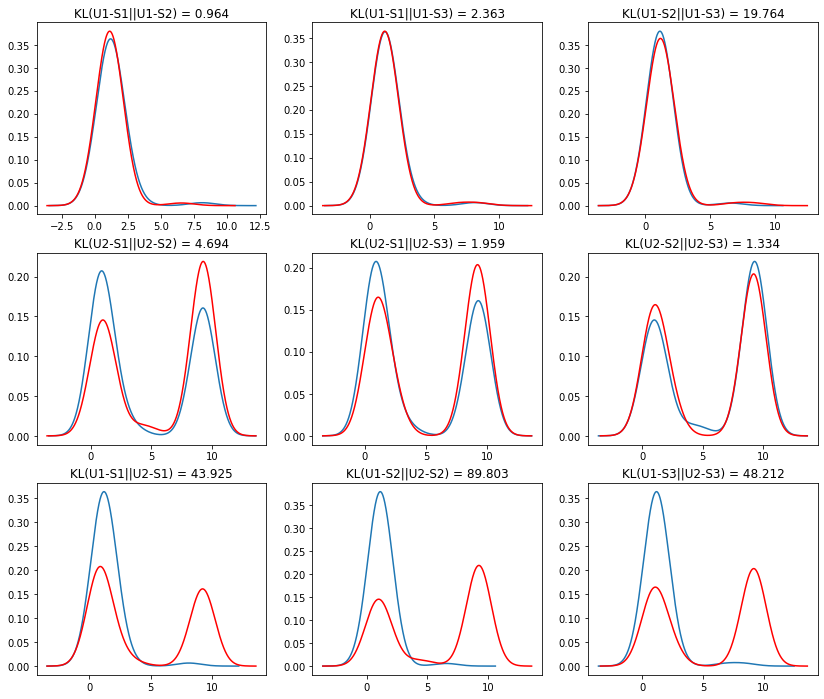

In [37]:
fig, axs = plt.subplots(3, 3, figsize = (14, 12))
axs[0,0].plot(x111_fixed, y111_fixed)
axs[0,0].plot(x121_fixed, y121_fixed, c='red')
axs[0,0].set_title('KL(U1-S1||U1-S2) = %1.3f' % kl_divergence(y111_fixed, y121_fixed))
axs[0,1].plot(x111_fixed, y111_fixed)
axs[0,1].plot(x131_fixed, y131_fixed, c='red')
axs[0,1].set_title('KL(U1-S1||U1-S3) = %1.3f' % kl_divergence(y111_fixed, y131_fixed))
axs[0,2].plot(x121_fixed, y121_fixed)
axs[0,2].plot(x131_fixed, y131_fixed, c='red')
axs[0,2].set_title('KL(U1-S2||U1-S3) = %1.3f' % kl_divergence(y121_fixed, y131_fixed))

axs[1,0].plot(x211_fixed, y211_fixed)
axs[1,0].plot(x221_fixed, y221_fixed, c='red')
axs[1,0].set_title('KL(U2-S1||U2-S2) = %1.3f' % kl_divergence(y211_fixed, y221_fixed))
axs[1,1].plot(x211_fixed, y211_fixed)
axs[1,1].plot(x231_fixed, y231_fixed, c='red')
axs[1,1].set_title('KL(U2-S1||U2-S3) = %1.3f' % kl_divergence(y211_fixed, y231_fixed))
axs[1,2].plot(x221_fixed, y221_fixed)
axs[1,2].plot(x231_fixed, y231_fixed, c='red')
axs[1,2].set_title('KL(U2-S2||U2-S3) = %1.3f' % kl_divergence(y221_fixed, y231_fixed))

axs[2,0].plot(x111_fixed, y111_fixed)
axs[2,0].plot(x211_fixed, y211_fixed, c='red')
axs[2,0].set_title('KL(U1-S1||U2-S1) = %1.3f' % kl_divergence(y111_fixed, y211_fixed))
axs[2,1].plot(x121_fixed, y121_fixed)
axs[2,1].plot(x221_fixed, y221_fixed, c='red')
axs[2,1].set_title('KL(U1-S2||U2-S2) = %1.3f' % kl_divergence(y121_fixed, y221_fixed))
axs[2,2].plot(x131_fixed, y131_fixed)
axs[2,2].plot(x231_fixed, y231_fixed, c='red')
axs[2,2].set_title('KL(U1-S3||U2-S3) = %1.3f' % kl_divergence(y131_fixed, y231_fixed))
plt.show()

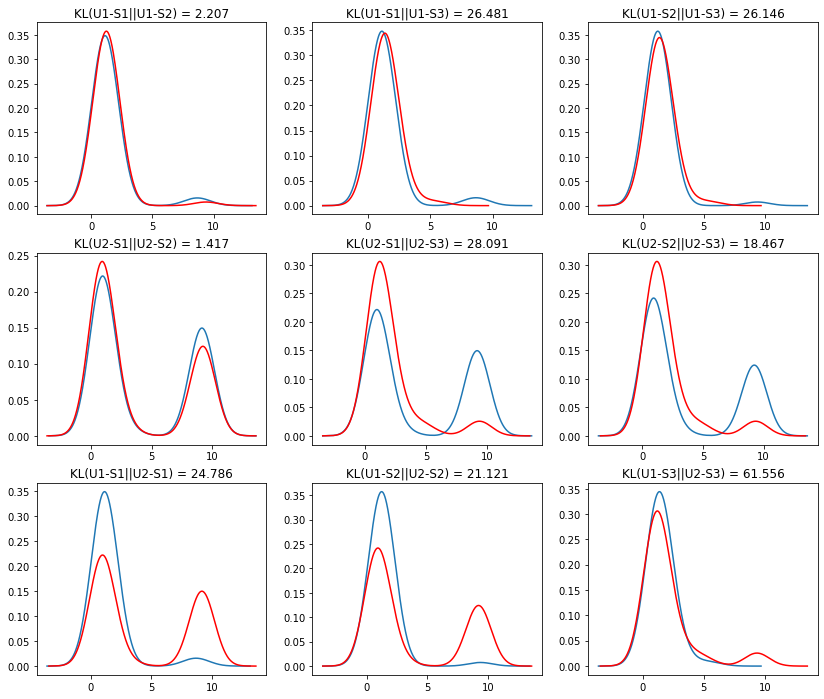

In [38]:
fig, axs = plt.subplots(3, 3, figsize = (14, 12))
axs[0,0].plot(x112_fixed, y112_fixed)
axs[0,0].plot(x122_fixed, y122_fixed, c='red')
axs[0,0].set_title('KL(U1-S1||U1-S2) = %1.3f' % kl_divergence(y112_fixed, y122_fixed))
axs[0,1].plot(x112_fixed, y112_fixed)
axs[0,1].plot(x132_fixed, y132_fixed, c='red')
axs[0,1].set_title('KL(U1-S1||U1-S3) = %1.3f' % kl_divergence(y112_fixed, y132_fixed))
axs[0,2].plot(x122_fixed, y122_fixed)
axs[0,2].plot(x132_fixed, y132_fixed, c='red')
axs[0,2].set_title('KL(U1-S2||U1-S3) = %1.3f' % kl_divergence(y122_fixed, y132_fixed))

axs[1,0].plot(x212_fixed, y212_fixed)
axs[1,0].plot(x222_fixed, y222_fixed, c='red')
axs[1,0].set_title('KL(U2-S1||U2-S2) = %1.3f' % kl_divergence(y212_fixed, y222_fixed))
axs[1,1].plot(x212_fixed, y212_fixed)
axs[1,1].plot(x232_fixed, y232_fixed, c='red')
axs[1,1].set_title('KL(U2-S1||U2-S3) = %1.3f' % kl_divergence(y212_fixed, y232_fixed))
axs[1,2].plot(x222_fixed, y222_fixed)
axs[1,2].plot(x232_fixed, y232_fixed, c='red')
axs[1,2].set_title('KL(U2-S2||U2-S3) = %1.3f' % kl_divergence(y222_fixed, y232_fixed))

axs[2,0].plot(x112_fixed, y112_fixed)
axs[2,0].plot(x212_fixed, y212_fixed, c='red')
axs[2,0].set_title('KL(U1-S1||U2-S1) = %1.3f' % kl_divergence(y112_fixed, y212_fixed))
axs[2,1].plot(x122_fixed, y122_fixed)
axs[2,1].plot(x222_fixed, y222_fixed, c='red')
axs[2,1].set_title('KL(U1-S2||U2-S2) = %1.3f' % kl_divergence(y122_fixed, y222_fixed))
axs[2,2].plot(x132_fixed, y132_fixed)
axs[2,2].plot(x232_fixed, y232_fixed, c='red')
axs[2,2].set_title('KL(U1-S3||U2-S3) = %1.3f' % kl_divergence(y132_fixed, y232_fixed))
plt.show()

In [39]:
col_head = ["Distance","User", "Type", "KL"]
data__fixed_f2 = [["Distance_1","both", "Inter",kl_divergence(y111_fixed, y211_fixed)],
        ["Distance_1","both", "Inter",kl_divergence(y121_fixed, y221_fixed)], 
        ["Distance_1","both", "Inter",kl_divergence(y131_fixed, y231_fixed)],
        ["Distance_2","both", "Inter",kl_divergence(y112_fixed, y212_fixed)],
        ["Distance_2","both", "Inter",kl_divergence(y122_fixed, y222_fixed)], 
        ["Distance_2","both", "Inter",kl_divergence(y132_fixed, y232_fixed)],
#         ["Distance_3", "Inter",kl_divergence(y113_fixed, y213_fixed)],
#         ["Distance_3", "Inter",kl_divergence(y123_fixed, y223_fixed)], 
#         ["Distance_3", "Inter",kl_divergence(y133_fixed, y233_fixed)],
        ["Distance_1","User1", "Intra",kl_divergence(y111_fixed, y121_fixed)],
        ["Distance_1","User1", "Intra",kl_divergence(y111_fixed, y131_fixed)], 
        ["Distance_1","User1", "Intra",kl_divergence(y121_fixed, y131_fixed)],
        ["Distance_1","User2", "Intra",kl_divergence(y211_fixed, y221_fixed)], 
        ["Distance_1","User2", "Intra",kl_divergence(y211_fixed, y231_fixed)], 
        ["Distance_1","User2", "Intra",kl_divergence(y221_fixed, y231_fixed)],
        ["Distance_2","User1", "Intra",kl_divergence(y112_fixed, y122_fixed)],
        ["Distance_2","User1", "Intra",kl_divergence(y112_fixed, y132_fixed)], 
        ["Distance_2","User1", "Intra",kl_divergence(y122_fixed, y132_fixed)],
        ["Distance_2","User2", "Intra",kl_divergence(y212_fixed, y222_fixed)], 
        ["Distance_2","User2", "Intra",kl_divergence(y212_fixed, y232_fixed)], 
        ["Distance_2","User2", "Intra",kl_divergence(y222_fixed, y232_fixed)]
#         ["Distance_3", "Intra",kl_divergence(y_fixed_113_f2, y_fixed_123_f2)],
#         ["Distance_3", "Intra",kl_divergence(y_fixed_113_f2, y_fixed_133_f2)], 
#         ["Distance_3", "Intra",kl_divergence(y_fixed_123_f2, y_fixed_133_f2)],
#         ["Distance_3", "Intra",kl_divergence(y_fixed_213_f2, y_fixed_223_f2)], 
#         ["Distance_3", "Intra",kl_divergence(y_fixed_213_f2, y_fixed_233_f2)], 
#         ["Distance_3", "Intra",kl_divergence(y_fixed_223_f2, y_fixed_233_f2)]
                 ]
fixed_KL = pd.DataFrame(data__fixed_f2, columns=col_head)

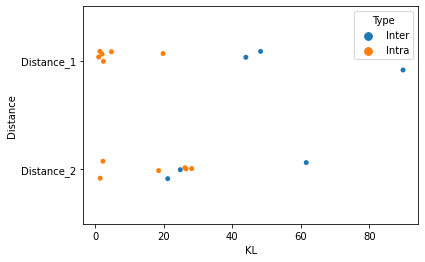

In [40]:
sns.stripplot(data= fixed_KL, x='KL',y='Distance', hue='Type')
# sns.stripplot(data= fixed_KL_f2, x='KL',y='Distance', hue='Type', ax=ax2)
# ax1.set_title("F1 for fixed text")
# ax2.set_title('F2 for fixed text')
plt.show()